In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/silk-dataset/silk_dataset/IMG_3946.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_2771.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_3912.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_3167.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_2760.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_2844.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_2765.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_2711.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_3114.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_2740.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_3538.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_2791.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_3095.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_3520.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_2987.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_3809.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_3030.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_3925.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_27

SAM masks will be saved in: /kaggle/working/sam_generated_masks
Using device: cuda
Checkpoint already exists at sam_vit_b_01ec64.pth, skipping download.
SAM model 'vit_b' and MaskGenerator loaded successfully.
Processing a subset of 150 randomly selected images.

Starting SAM mask generation...


Generating SAM Masks: 100%|██████████| 150/150 [5:28:42<00:00, 131.48s/it]  



SAM mask generation completed. Processed: 150, Skipped: 0

--- End of SAM mask generation code ---

--- Visualizing generated SAM masks with custom colors ---


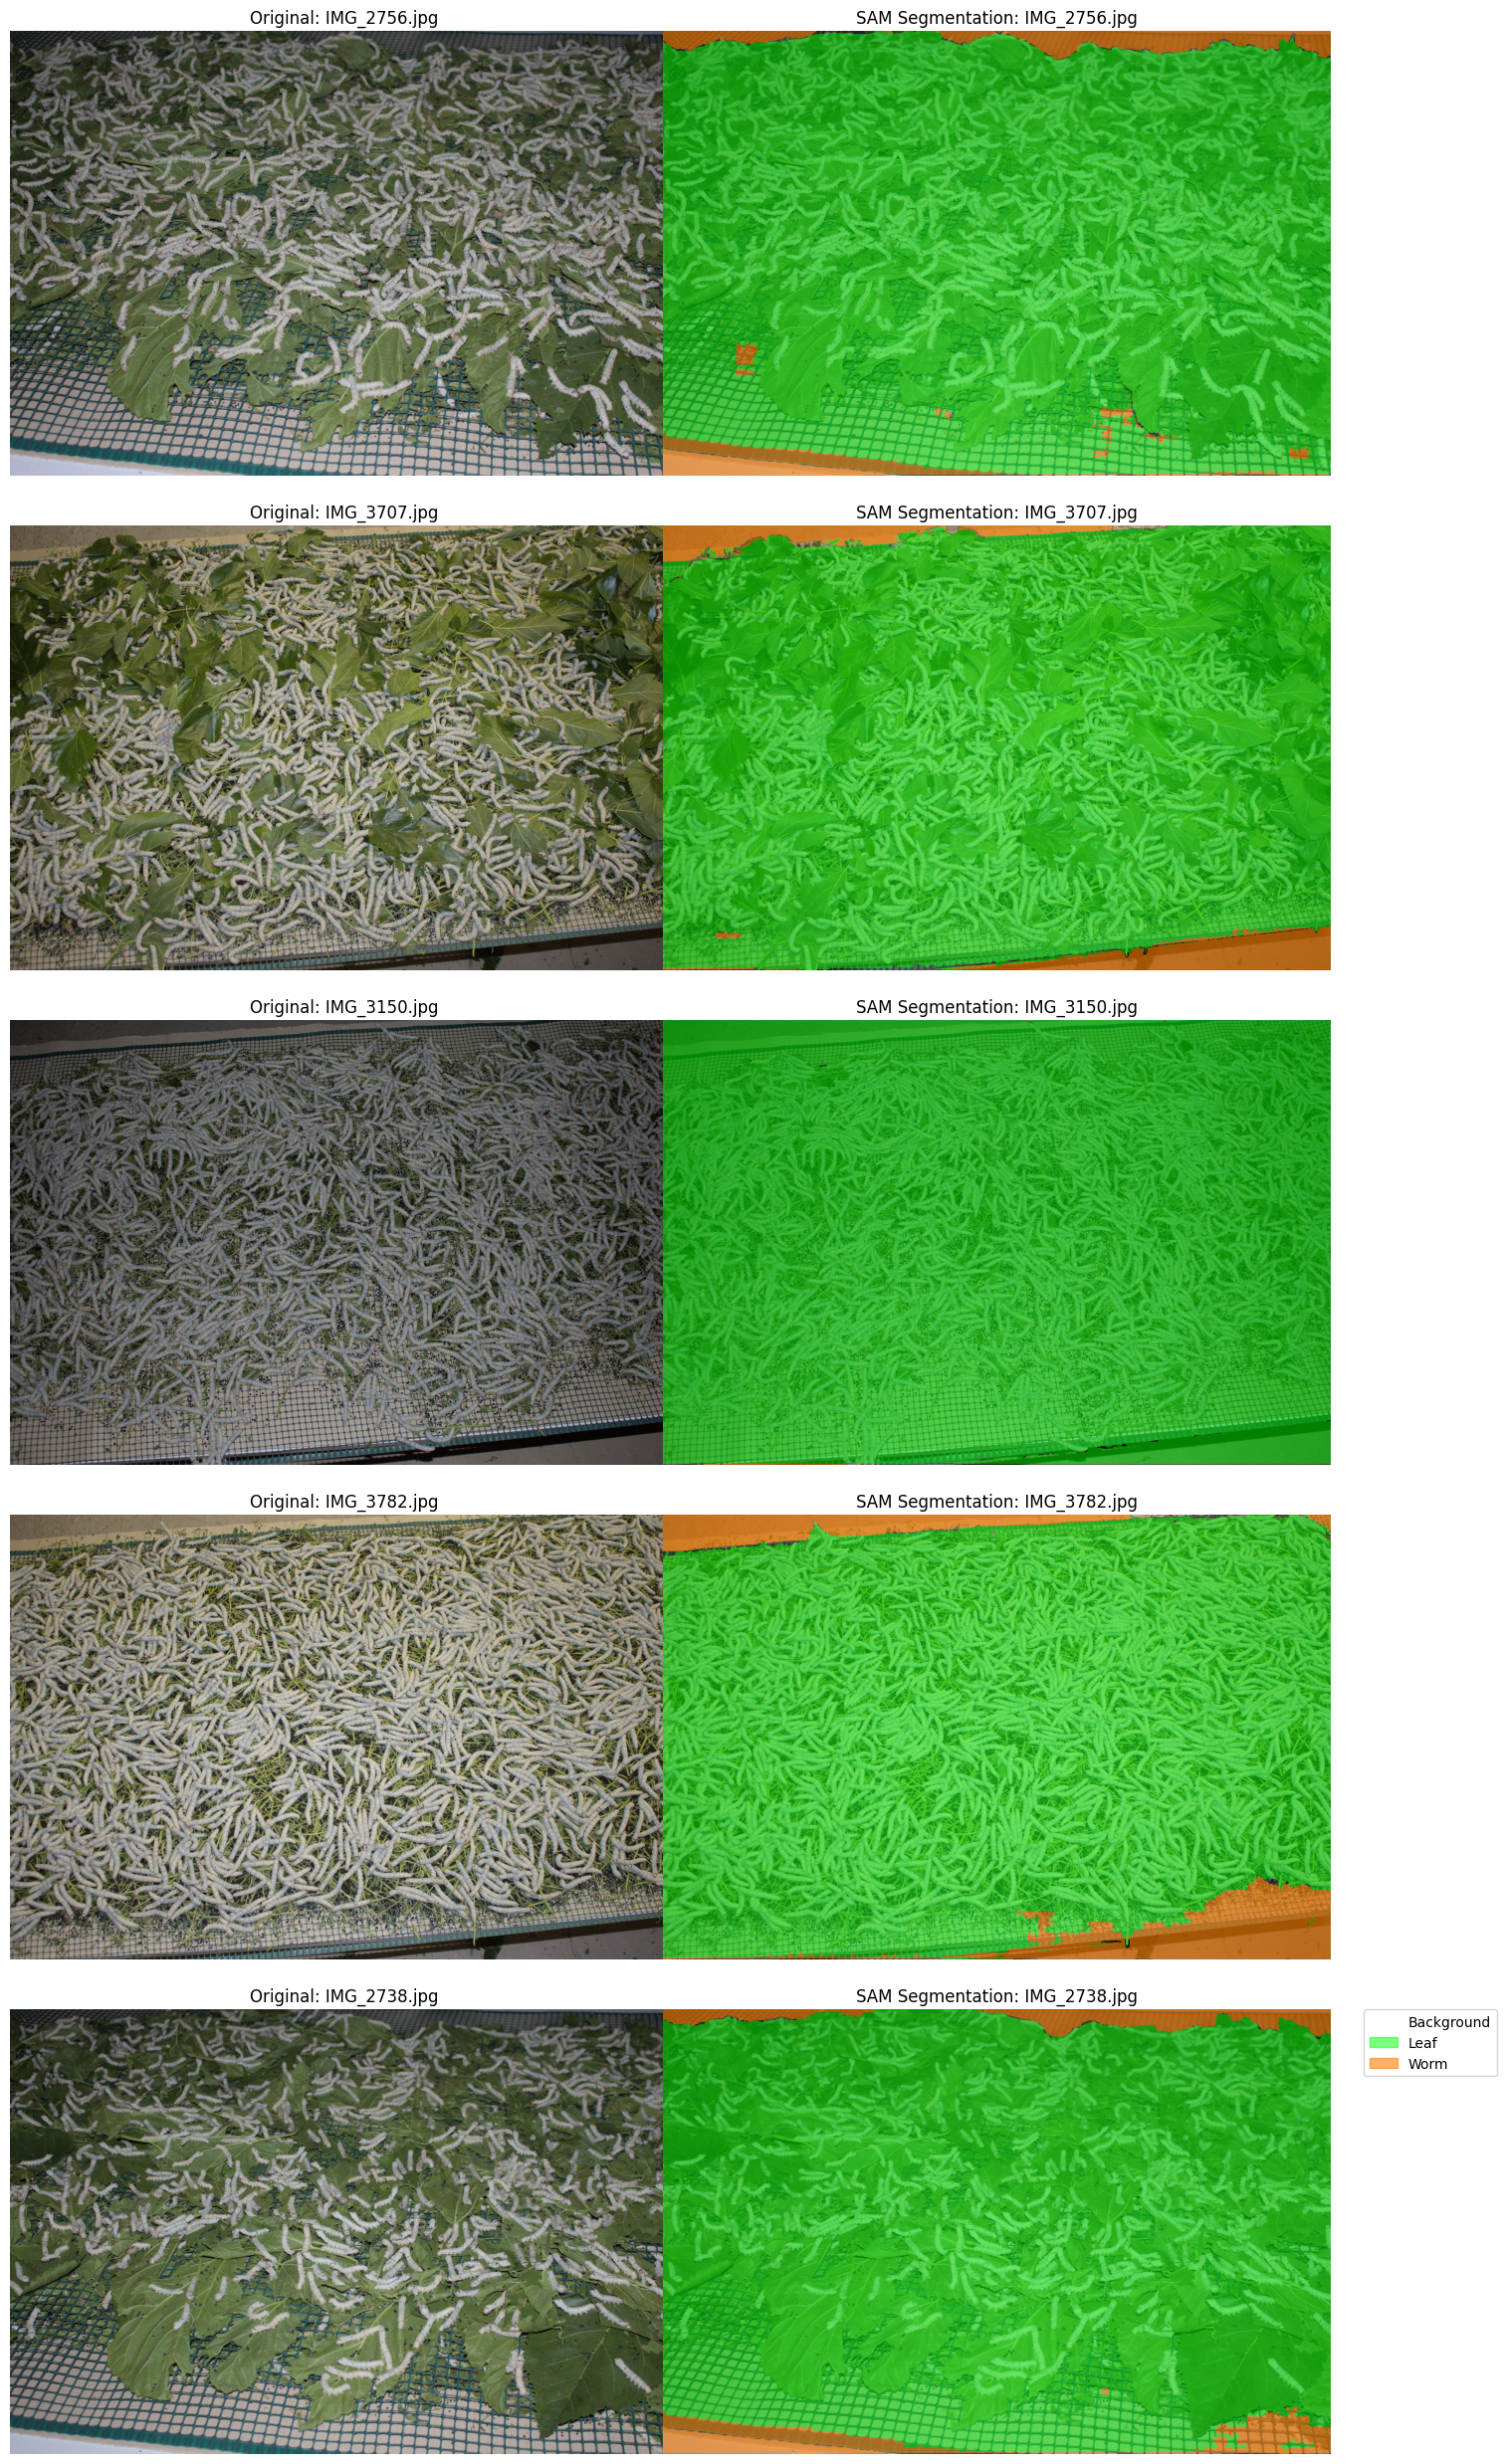


--- End of SAM generation and visualization process ---


In [6]:
import os
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
import torchvision.transforms as transforms
import requests # For downloading the checkpoint
import random # For random image selection (if not from CSV)
import matplotlib.pyplot as plt # For visualization
import matplotlib.colors as mcolors # For creating a custom colormap
import matplotlib.patches as mpatches

# --- 0. Initial Configuration and Paths ---
IMAGES_INPUT_DIR = '/kaggle/input/silk-dataset/silk_dataset' # Directory containing the input images
OUTPUT_MASKS_DIR = '/kaggle/working/sam_generated_masks' # Directory where the generated SAM masks will be saved

os.makedirs(OUTPUT_MASKS_DIR, exist_ok=True) # Create the output directory if it doesn't exist
print(f"SAM masks will be saved in: {OUTPUT_MASKS_DIR}")

# --- Check and Enable GPU if Available ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Automatically detect and use CUDA (GPU) if available, otherwise fall back to CPU.
print(f"Using device: {device}")
if device.type == 'cpu':
    print("WARNING: You are using the CPU. SAM mask generation will be VERY SLOW.")
    print("Consider enabling GPU in Kaggle notebook options (if available).")

# --- Install the segment-anything library ---

!pip install segment-anything

# --- 1. SAM Specific Configuration and Preprocessing Parameters ---
sam_model_type = "vit_b" # Specifies the type of SAM model to use (Vision Transformer Base).
sam_checkpoint_url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth" # URL to download the pre-trained SAM checkpoint.
sam_checkpoint_path = "sam_vit_b_01ec64.pth" # Local path where the SAM checkpoint will be saved.

FOURIER_RADIUS = 30 # Radius for the Fourier high-pass filter.
GREEN_HUE_MIN = 40 # Minimum hue value for green color range.
GREEN_HUE_MAX = 90 # Maximum hue value for green color range.
GREEN_SATURATION_BOOST = 1.5 # Factor to boost saturation for green regions.
RED_HUE_LOW = 20 # Lower bound of hue for red color range (red wraps around the hue circle).
RED_HUE_HIGH = 160 # Upper bound of hue for red color range.
CLAHE_CLIP_LIMIT = 2.0 # Clipping limit for Contrast Limited Adaptive Histogram Equalization (CLAHE).
CLAHE_TILE_SIZE = (8, 8) # Tile grid size for CLAHE.
MIN_MASK_AREA = 500 # Minimum area (in pixels) for a generated mask to be considered valid and kept.

# --- NEW CONFIGURATION: Number of images to process ---
NUMBER_OF_SAMPLES_TO_PROCESS = 150 # We set this value and processed all the images 

# --- 2. Utility Functions for Preprocessing and Mask Classification ---
def download_checkpoint(url: str, destination: str):
    """
    Downloads a file from a given URL to a specified destination path.
    Skips download if the file already exists.
    """
    if not os.path.exists(destination):
        print(f"Downloading SAM checkpoint from {url} to {destination}…")
        response = requests.get(url, allow_redirects=True) # Send a GET request to the URL.
        with open(destination, "wb") as f: # Open the destination file in binary write mode.
            f.write(response.content) # Write the downloaded content to the file.
        print("Download complete.")
    else:
        print(f"Checkpoint already exists at {destination}, skipping download.")

def apply_gray_world(image: np.ndarray) -> np.ndarray:
    """
    Applies the Gray World assumption for color balancing an image.
    It assumes the average color of a scene is neutral gray.
    """
    img32 = image.astype(np.float32) # Convert image to float32 for calculations.
    channel_means = img32.mean(axis=(0, 1)) # Calculate the mean intensity for each color channel.
    scale = channel_means.mean() / (channel_means + 1e-6) # Calculate scaling factor for each channel, avoiding division by zero.
    balanced = img32 * scale # Apply the scaling to balance the colors.
    return np.clip(balanced, 0, 255).astype(np.uint8) # Clip values to 0-255 range and convert back to uint8.

def high_pass_filter(gray_image: np.ndarray, radius: int = FOURIER_RADIUS) -> np.ndarray:
    """
    Applies a circular high-pass filter in the Fourier domain to a grayscale image.
    This enhances edges and fine details by attenuating low-frequency components.
    """
    h, w = gray_image.shape # Get height and width of the grayscale image.
    cy, cx = h // 2, w // 2 # Calculate the center coordinates.
    dft = cv2.dft(gray_image.astype(np.float32), flags=cv2.DFT_COMPLEX_OUTPUT) # Compute 2D Discrete Fourier Transform.
    dft_shift = np.fft.fftshift(dft) # Shift the zero-frequency component to the center.
    mask = np.ones((h, w, 2), np.uint8) # Create a mask filled with ones (for real and imaginary parts).
    # Create a circular region of zeros at the center of the mask. This blocks low frequencies.
    cv2.circle(mask, (cx, cy), radius, 0, -1) 
    fshift = dft_shift * mask # Apply the mask to the shifted DFT.
    f_ishift = np.fft.ifftshift(fshift) # Shift the zero-frequency component back.
    img_back = cv2.idft(f_ishift) # Compute the Inverse Discrete Fourier Transform.
    mag = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1]) # Calculate the magnitude of the complex output.
    return cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8) # Normalize to 0-255 and convert to uint8.

def preprocess_image(image_rgb: np.ndarray) -> np.ndarray:
    """
    Applies a series of image preprocessing steps to an RGB image to enhance it for segmentation.
    Includes gray-world balancing, CLAHE for contrast, high-pass filtering for detail,
    and selective hue/saturation adjustments.
    """
    balanced = apply_gray_world(image_rgb) # Apply gray world color balance.
    lab = cv2.cvtColor(balanced, cv2.COLOR_RGB2LAB) # Convert to LAB color space.
    L, A, B = cv2.split(lab) # Split LAB channels.
    clahe = cv2.createCLAHE(clipLimit=CLAHE_CLIP_LIMIT, tileGridSize=CLAHE_TILE_SIZE) # Create CLAHE object.
    L_eq = clahe.apply(L) # Apply CLAHE to the Luminance (L) channel.
    contrast = cv2.cvtColor(cv2.merge((L_eq, A, B)), cv2.COLOR_LAB2RGB) # Merge channels back and convert to RGB.

    gray = cv2.cvtColor(contrast, cv2.COLOR_RGB2GRAY) # Convert to grayscale for high-pass filter.
    hp = high_pass_filter(gray) # Apply high-pass filter.
    # Blend the high-pass filtered result with the contrast-enhanced image.
    enhanced = cv2.addWeighted(contrast, 1.0, cv2.cvtColor(hp, cv2.COLOR_GRAY2RGB), 0.5, 0)

    hsv = cv2.cvtColor(enhanced, cv2.COLOR_RGB2HSV).astype(np.float32) # Convert to HSV for hue/saturation adjustment.
    H, S, V = hsv[..., 0], hsv[..., 1], hsv[..., 2] # Split HSV channels.
    
    # Boost saturation for green regions.
    green_zone = (H >= GREEN_HUE_MIN) & (H <= GREEN_HUE_MAX)
    S[green_zone] *= GREEN_SATURATION_BOOST
    
    # Desaturate red regions (as they might be less relevant or distracting).
    red_zone = (H <= RED_HUE_LOW) | (H >= RED_HUE_HIGH) # Red hue wraps around, so check both ends.
    S[red_zone] *= 0.6 # Reduce saturation for red.
    
    hsv[..., 1] = np.clip(S, 0, 255) # Clip saturation values to valid range.
    hsv_processed = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB) # Convert back to RGB.

    return hsv_processed

# --- 3. SAM Model Initialization ---
_sam_available = False # Flag to track if SAM model was loaded successfully.
try:
    from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor # Import necessary SAM classes.
    
    download_checkpoint(sam_checkpoint_url, sam_checkpoint_path) # Download the SAM model checkpoint.
    # Load the SAM model and move it to the specified device (GPU/CPU).
    sam = sam_model_registry[sam_model_type](checkpoint=sam_checkpoint_path).to(device)
    
    # Initialize SamAutomaticMaskGenerator for generating multiple masks per image.
    mask_generator = SamAutomaticMaskGenerator(
        model=sam,
        points_per_side=64, # Number of points to sample along each side of the image for mask generation.
        crop_n_layers=1, # Number of layers to crop the image into for multi-scale processing.
        pred_iou_thresh=0.7, # IoU (Intersection over Union) threshold for filtering low-quality masks.
        stability_score_thresh=0.7, # Stability score threshold for filtering unstable masks.
        min_mask_region_area=MIN_MASK_AREA, # Minimum area in pixels for a mask to be kept.
    )
    print(f"SAM model '{sam_model_type}' and MaskGenerator loaded successfully.")
    _sam_available = True # Set flag to True if SAM is ready.
except Exception as e:
    print(f"ERROR: Failed to load SAM model: {e}")
    print("Please ensure the 'segment-anything' library is installed, the checkpoint path is correct, and the SAM model type is valid.")
    print("SAM mask generation will not be possible.")

# --- 4. List of Images to Process ---
image_filenames = [] # This will store the names of the selected images to process.
all_image_filenames_from_csv = [] # This will temporarily hold all image names read from the CSV.

try:
    import pandas as pd # Import pandas for reading CSV.
    original_csv_path = os.path.join(IMAGES_INPUT_DIR, '0_data.csv') # Path to the CSV file containing image information.
    original_df = pd.read_csv(original_csv_path) # Read the CSV into a pandas DataFrame.
    all_image_filenames_from_csv = [os.path.basename(f) for f in original_df['foto'].tolist()] # Extract base filenames from 'foto' column.
except FileNotFoundError:
    print(f"ERROR: Dataset CSV file not found: {original_csv_path}")

if not all_image_filenames_from_csv:
    print("No images found for SAM processing.")
else:
    # If a specific number of samples is requested and it's less than total available images.
    if NUMBER_OF_SAMPLES_TO_PROCESS > 0 and NUMBER_OF_SAMPLES_TO_PROCESS < len(all_image_filenames_from_csv):
        # Randomly sample the specified number of images.
        image_filenames = random.sample(all_image_filenames_from_csv, NUMBER_OF_SAMPLES_TO_PROCESS)
        print(f"Processing a subset of {NUMBER_OF_SAMPLES_TO_PROCESS} randomly selected images.")
    else:
        # If NUMBER_OF_SAMPLES_TO_PROCESS is 0 or greater than/equal to total, process all images.
        image_filenames = all_image_filenames_from_csv
        NUMBER_OF_SAMPLES_TO_PROCESS = len(image_filenames) # Update to reflect the actual number being processed.
        print(f"Processing ALL {len(image_filenames)} available images.")


# --- 5. SAM Mask Generation and Saving ---
generated_mask_paths = {} # Dictionary to store paths of successfully generated masks (filename -> mask_path).
original_image_paths_for_display = {} # Dictionary to store paths of original images for display (filename -> img_path).

if _sam_available and image_filenames: # Proceed only if SAM is loaded and images are found.
    print("\nStarting SAM mask generation...")
    processed_count = 0 # Counter for successfully processed images.
    skipped_count = 0 # Counter for skipped images.

    for img_filename_base in tqdm(image_filenames, desc="Generating SAM Masks"): # Iterate through selected image filenames with a progress bar.
        img_path = os.path.join(IMAGES_INPUT_DIR, img_filename_base) # Full path to the original image.

        if not os.path.exists(img_path): # Check if the original image file exists.
            print(f"Warning: Original image not found, skipping: {img_path}")
            skipped_count += 1
            continue # Skip to the next image.

        try:
            image_bgr = cv2.imread(img_path) # Load image using OpenCV (loads in BGR format).
            image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB) # Convert from BGR to RGB.
            
            preprocessed_image_rgb = preprocess_image(image_rgb) # Apply custom preprocessing to the image.
            
            sam_masks = mask_generator.generate(preprocessed_image_rgb) # Generate automatic masks using SAM.

            # Initialize a blank segmentation mask with pixel values representing classes.
            # 0: Background, 1: Leaf, 2: Worm.
            final_segmentation_mask = np.zeros(image_rgb.shape[:2], dtype=np.uint8)
            
            if sam_masks: # If SAM generated any masks:
                # Sort masks by area in descending order (larger masks first).
                sam_masks_sorted = sorted(sam_masks, key=lambda x: x['area'], reverse=True)
                
                worm_mask_temp = np.zeros_like(final_segmentation_mask, dtype=np.bool_) # Temporary boolean mask for worms.
                leaf_mask_temp = np.zeros_like(final_segmentation_mask, dtype=np.bool_) # Temporary boolean mask for leaves.

                # Iterate through each generated SAM mask.
                for mask_info in sam_masks_sorted:
                    seg = mask_info['segmentation'] # Get the binary segmentation mask (boolean array).
                    
                    if seg.sum() < MIN_MASK_AREA: # Filter out masks smaller than the minimum area.
                        continue
                    
                    # Calculate the mean hue of the preprocessed image within the current mask region.
                    # This is used to classify the mask as 'leaf' or 'worm'.
                    mean_hue = cv2.mean(cv2.cvtColor(preprocessed_image_rgb, cv2.COLOR_RGB2HSV)[:, :, 0], mask=seg.astype(np.uint8))[0]
                    
                    # Classify based on hue. Green objects (leaves) fall into a specific hue range.
                    if GREEN_HUE_MIN <= mean_hue <= GREEN_HUE_MAX:
                        # Assign to leaf mask. Use `~worm_mask_temp` to prioritize leaves over worms if regions overlap.
                        leaf_mask_temp[seg & ~worm_mask_temp] = True
                    else:
                        # Otherwise, classify as worm. Use `~leaf_mask_temp` to avoid overwriting existing leaf pixels.
                        worm_mask_temp[seg & ~leaf_mask_temp] = True
                
                # Convert temporary boolean masks to final uint8 masks with class IDs.
                final_segmentation_mask[leaf_mask_temp] = 1 # Assign 1 for Leaf class.
                final_segmentation_mask[worm_mask_temp] = 2 # Assign 2 for Worm class.

            # Resize the generated mask to the original image's resolution using nearest-neighbor interpolation.
            mask_full_res = cv2.resize(
                final_segmentation_mask,
                (image_bgr.shape[1], image_bgr.shape[0]), # Target size (width, height) from original image.
                interpolation=cv2.INTER_NEAREST # Use nearest-neighbor for mask resizing to preserve integer labels.
            )
            
            # Define the output filename and path for the generated mask.
            mask_output_filename = f"sam_{os.path.splitext(img_filename_base)[0]}.png"
            output_mask_path = os.path.join(OUTPUT_MASKS_DIR, mask_output_filename)
            
            # Save the generated mask as a PNG image.
            Image.fromarray(mask_full_res).save(output_mask_path)
            processed_count += 1
            
            # NEW: Store the path of the generated mask and the original image for later visualization.
            generated_mask_paths[img_filename_base] = output_mask_path
            original_image_paths_for_display[img_filename_base] = img_path

        except Exception as e:
            print(f"Error during SAM processing of {img_filename_base}: {e}")
            skipped_count += 1 # Increment skipped count if an error occurs.
            continue # Continue to the next image.

    print(f"\nSAM mask generation completed. Processed: {processed_count}, Skipped: {skipped_count}")
else:
    print("\nSkipping SAM mask generation (model not available or no images to process).")

print("\n--- End of SAM mask generation code ---")

# ---  Application and Visualization of Generated Masks with Custom Colors ---
print("\n--- Visualizing generated SAM masks with custom colors ---")

if generated_mask_paths: # Proceed only if there are generated masks to visualize.
    # Determine the actual number of samples to display, up to NUMBER_OF_SAMPLES_TO_PROCESS.
    num_display_samples = 5
    # Randomly select image base names for visualization from the generated masks.
    display_image_bases = random.sample(list(generated_mask_paths.keys()), num_display_samples)

    plt.figure(figsize=(15, 5 * num_display_samples)) # Create a figure, adjusting height for multiple rows of plots.

    # --- CUSTOM COLOR DEFINITION ---
    # We defined custom colors as RGBA tuples (Red, Green, Blue, Alpha) with values from 0.0 to 1.0.
    # These correspond to the class IDs: 0 = Background, 1 = Leaf, 2 = Worm.
    custom_colors = [
        [0.0, 0.0, 0.0, 0.0],  # Class 0: Background (Transparent - black with alpha 0.0)
        [0.0, 1.0, 0.0, 0.5],  # Class 1: Leaf (Green, semi-transparent)
        [1.0, 0.5, 0.0, 0.6]    # Class 2: Worm (Orange, semi-transparent)
    ]
    # Create a Matplotlib colormap object from this list of custom colors.
    custom_cmap = mcolors.ListedColormap(custom_colors)

    # A dictionary for mapping class labels to display names (for legend).
    CLASS_LABELS = {0: "Background", 1: "Leaf", 2: "Worm"} # Updated labels to English


    for j, img_base in enumerate(display_image_bases): # Iterate through selected images for display.
        original_img_path = original_image_paths_for_display[img_base] # Get path to original image.
        mask_path = generated_mask_paths[img_base] # Get path to generated mask.

        try:
            original_image_rgb = Image.open(original_img_path).convert('RGB') # Load original image in RGB.
            mask_image = Image.open(mask_path).convert('L') # Load the mask image in grayscale (L mode).

            original_image_np = np.array(original_image_rgb) # Convert original image to NumPy array.
            mask_np = np.array(mask_image) # Convert mask image to NumPy array.
            
            # --- For visualization, we applied the custom colormap ---
            # The 'mask_np' already contains pixel values 0, 1, 2.
            # These values will be used directly as indices for the 'custom_cmap',
            # which returns an RGBA array.
            colors_map_applied = custom_cmap(mask_np) # This produces an RGBA array.

            # --- Plotting ---
            # Subplot for the Original Image.
            plt.subplot(num_display_samples, 2, j * 2 + 1) # (rows, columns, plot_number)
            plt.imshow(original_image_np)
            plt.title(f"Original: {img_base}") # Title includes original filename.
            plt.axis('off') # Turn off axis labels and ticks.

            # Subplot for the SAM Segmented Mask Overlay.
            plt.subplot(num_display_samples, 2, j * 2 + 2)
            plt.imshow(original_image_np) # Display the original image as a background.
            # Overlay the colored mask with its alpha channel for transparency.
            plt.imshow(colors_map_applied) 
            plt.title(f"SAM Segmentation: {img_base}") # Title for the segmented image.
            plt.axis('off')

            # Added a legend to the very last plot to explain the colors.
            if j == num_display_samples -1:
                # Create patches for the legend corresponding to each class color.
                handles = [mpatches.Patch(color=custom_colors[i], label=CLASS_LABELS[i])
                           for i in sorted(CLASS_LABELS.keys())]
                # Position the legend outside the plot area.
                plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

        except Exception as e:
            print(f"Error during visualization of {img_base}: {e}")
            # If an error occurs during visualization, clear the subplots and show an error title.
            plt.subplot(num_display_samples, 2, j * 2 + 1)
            plt.axis('off'); plt.title(f"Error: {img_base}")
            plt.subplot(num_display_samples, 2, j * 2 + 2)
            plt.axis('off'); plt.title(f"Error: {img_base}")
            continue # Continue to the next image for visualization.
    
    plt.tight_layout() # Adjust subplot parameters for a tight layout.
    plt.show() # Display all generated plots.
else:
    print("No SAM masks generated for visualization.")

print("\n--- End of SAM generation and visualization process ---")

In [8]:
SAM_MASKS_DIR = '/kaggle/working/sam_generated_masks'

SAM_ZIP_FILE_PATH = '/kaggle/working/sam_generated_masks'

print(f"Zipping the folder: {SAM_MASKS_DIR} in {SAM_ZIP_FILE_PATH}...")

!zip -r {SAM_ZIP_FILE_PATH} {SAM_MASKS_DIR}

print("Complete!")
print(f"File ZIP '{SAM_ZIP_FILE_PATH}' created.")

Zipping the folder: /kaggle/working/sam_generated_masks in /kaggle/working/sam_generated_masks...
  adding: kaggle/working/sam_generated_masks/ (stored 0%)
  adding: kaggle/working/sam_generated_masks/sam_IMG_3338.png (deflated 26%)
  adding: kaggle/working/sam_generated_masks/sam_IMG_3198.png (deflated 62%)
  adding: kaggle/working/sam_generated_masks/sam_IMG_2826.png (deflated 49%)
  adding: kaggle/working/sam_generated_masks/sam_IMG_3418.png (deflated 38%)
  adding: kaggle/working/sam_generated_masks/sam_IMG_2998.png (deflated 75%)
  adding: kaggle/working/sam_generated_masks/sam_IMG_2907.png (deflated 48%)
  adding: kaggle/working/sam_generated_masks/sam_IMG_3886.png (deflated 38%)
  adding: kaggle/working/sam_generated_masks/sam_IMG_3956.png (deflated 41%)
  adding: kaggle/working/sam_generated_masks/sam_IMG_2880.png (deflated 42%)
  adding: kaggle/working/sam_generated_masks/sam_IMG_3262.png (deflated 0%)
  adding: kaggle/working/sam_generated_masks/sam_IMG_3348.png (deflated 40%